# mat 파일을 pandas 데이터프레임으로 변환하여 feather 파일로 저장하기

## revision
- 2024-07-28: 
    - initail
    - mat to dataframe to feather 변환을 구현함
- 2024-07-29: 
    - TSMaster의 blf to mat 변환 시, 계산에 필요한 신호들만 선택하는 방법을 적용함
        - WHL_SPD11(0x386), SAS11 (0x2b0), ESP12 (0x153)  
- 2024-10-04: 블로그 포스팅을 위해서 내용을 정리함

## 개요
- TSMaster는 CAN 데이터를 blf 포맷으로 저장한다. blf는 CAN 통신을 메시지 단위로 저장하기에 메시지 단위로 데이터를 처리할 경우 좋다. 반면에 메시지와 시그날 구성 정보(소위 CAN 데이터베이스)가 없고, 시그날 단위로 데이터 처리를 할 수 없다는 단점이 있다. 이런 단점을 극복하고자 대부분의 CAN 측정 도구들은 시그날 별로 데이터를 볼 수 있는 포맷으로 파일 변환을 지원한다. 
- 시그날 기반 포맷으로 mdf와 mat가 대표적이다. 
    - mdf는 자동차 산업의 표준이다. 따라서 많은 도구들이 지원한다. 
    - mat은 Matlab의 표준이다. 많은 학생들이 대학교에서 Matlab을 배운다. mat 파일은 사용자가 많다. 
    - TSMaster는 blf to mat 포맷 변환을 지원한다. 
- 요즘 데이터 처리 많이 사용되는 언어는 Python이다. 데이터 처리를 위한 함수를 직접 개발하지 않고 미리 개발되어 공개된 함수를 가져와서 사용할 수 있다는 매우 커다란 장점이 있다. 이러 함수들의 모임을 모듈이라고 한다. 대표적으로 numpy(넘파이), scipy(사이파이), pandas(판다스)를 들 수 있다. 모듈을 import 하는 것으로 모듈에 포함된 함수들을 사용할 준비가 완료된다. 이 실습에서는 판다스와 사이파이의 함수들을 이용해서 디셀 유니포머티를 계산할 것이다. 
- 실습에는 두 개의 파이썬 스크립트가 사용된다. 첫 번째 스크립트인 이 스크립트에서는 mat의 데이터를 읽어, 판다스 데이터프레임으로 변환한다. 이 변환에 제법 시간이 든다. 스크립트 개발 중에 데이터 파일을 반복해서 읽게 된다. 그때마다 mat을 데이터프레임으로 변환하는 시간을 줄이기 위해, 데이터프레임을 판다스에서 읽기 쉬운 feather 형식 파일로 저장해둔다.
- 두 번째 스크립트에는 제동 성능 지표를 계산한다. 상세는 두 번째 스크립트의 개요에서 설명한다.


In [1]:
# import

import sys
from pathlib import Path
import h5py
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image

In [2]:
# 블로그에 올리기 위해 plotly renderer의 설정이 필요하다. 

import plotly.io as pio
pio.renderers.default = "notebook_connected" 

## 준비

In [3]:
# constant

# 프로젝트 디렉토리 경로
k_dir_project = Path('.').absolute()

# 데이터 파일 저장 경로
k_dir_data = Path(r'C:\data\tosun\projects\20240725_venue\Logging\Bus')
if k_dir_data.exists():
    print(f'{k_dir_data = }')
else:
    print('No data directory found')
    sys.exit(1)


k_dir_data = WindowsPath('C:/data/tosun/projects/20240725_venue/Logging/Bus')


In [4]:
# data 디렉토리에 feather 파일이 많이 있을 경우, 전체 feather 파일을 출력하여 확인한다.
mats = list(Path(k_dir_data).rglob('*.mat'))
print('mats =')
for i, mat in enumerate(mats):
    print(f'{i}: {mat.name}')


mats =
0: 20240725_venue2024_07_26_09_17_29.MAT


In [5]:
# 1개 mat 파일을 대상으로 데이터를 처리한다.
i_mat = 0
mat = mats[i_mat] 
print(f'{mat = }')


# pandas 데이터프레임을 저장할 feather 파일 이름을 미리 마련한다.
feather = mat.with_suffix('.feather')
print(f'{feather = }')


mat = WindowsPath('C:/data/tosun/projects/20240725_venue/Logging/Bus/20240725_venue2024_07_26_09_17_29.MAT')
feather = WindowsPath('C:/data/tosun/projects/20240725_venue/Logging/Bus/20240725_venue2024_07_26_09_17_29.feather')


## mat 파일을 읽어서 데이터프레임으로 변환하기
- 바퀴 속도 신호 데이터프레임을 만든다. 이 과정에서 mat 파일에서 데이터프레임을 방법을 알아낸다.
- 메시지별로 전송 주기가 다르다. 전송 주기를 맞춰야 제동 성능 지표 계산이 편리하다. 메시지별로 데이터프레임을 만들고, 데이터프레임들을 합친다.

In [6]:
# Read mat file. So simple
trace = h5py.File(mat, 'r')
trace_keys = list(trace.keys())
for key in trace_keys[:3]:
    print(key)


CAN1_ACU14_CF_SBR_Ind
CAN1_ACU14_CF_TTL_Ind
CAN1_CGW1_CF_Gway_AstDrSw


- mat 파일에 시그날 이름은 아래 명명법으로 되어있다. 
    - [network name]_[message name]_[signal name]
    - CAN1_WHL_SPD11_WHL_SPD_FL
        - CAN1: 네트워크 이름/ 채널 이름
        - WHL_SPD11: 메시지 이름
        - WHL_SPD_FL: 신호 이름

## 바퀴 속도 신호 데이터프레임 만들기
- 바퀴 속도 신호들은 WHL_SPD11 메시지에 들어있다.

In [7]:
# 바퀴 속도 속도 신호들로 데이터프레임(df_ws)을 만든다.
# 네 ws 시그널들이 한 메시지에 포함되어 있어서 타임스탬프(ts)가 동일할 것이다. 
# 확인을 위해서 ts를 wheel 별로 따로 만들어서 확인한다. 
ws = {}
wheels = ['fl', 'fr', 'rl', 'rr']  
df_ws = pd.DataFrame()
for wheel in wheels:
    ws[wheel] = np.array(trace[f'CAN1_WHL_SPD11_WHL_SPD_{wheel.upper()}'])
    df_ws[f'ts_{wheel}'] = ws[wheel][0, :]
    df_ws[f'ws_{wheel}'] = ws[wheel][1, :]

df_ws.tail(3)

,ts_fl,ws_fl,ts_fr,ws_fr,ts_rl,ws_rl,ts_rr,ws_rr
19193,456.265543,0.0,456.265543,0.0,456.265543,0.0,456.265543,0.0
19194,456.285776,0.0,456.285776,0.0,456.285776,0.0,456.285776,0.0
19195,456.305758,0.0,456.305758,0.0,456.305758,0.0,456.305758,0.0


In [8]:
# wheel별 ts(ts_wheel)가 같은지 확인한다.
for wheel_1 in wheels:
    for wheel_2 in wheels:
        if wheel_1 != wheel_2:
            print(f'Comparing {wheel_1} and {wheel_2}', end=' ')
            print((df_ws[f'ts_{wheel_1}'] != df_ws[f'ts_{wheel_2}']).sum(), 'difference(s) found')
# 예상대로 wheel 별로 ts 차이가 없다. 


Comparing fl and fr 0 difference(s) found
Comparing fl and rl 0 difference(s) found
Comparing fl and rr 0 difference(s) found
Comparing fr and fl 0 difference(s) found
Comparing fr and rl 0 difference(s) found
Comparing fr and rr 0 difference(s) found
Comparing rl and fl 0 difference(s) found
Comparing rl and fr 0 difference(s) found
Comparing rl and rr 0 difference(s) found
Comparing rr and fl 0 difference(s) found
Comparing rr and fr 0 difference(s) found
Comparing rr and rl 0 difference(s) found


In [9]:
# 대표 timestamp를 ts로 정하고 나머지는 제거한다.
df_ws['ts'] = df_ws[f'ts_{wheels[0]}']
df_ws.drop(columns=[f'ts_{wheel}' for wheel in wheels], inplace=True)
df_ws = df_ws[['ts'] + [f'ws_{wheel}' for wheel in wheels]]
df_ws.tail(3)

,ts,ws_fl,ws_fr,ws_rl,ws_rr
19193,456.265543,0.0,0.0,0.0,0.0
19194,456.285776,0.0,0.0,0.0,0.0
19195,456.305758,0.0,0.0,0.0,0.0


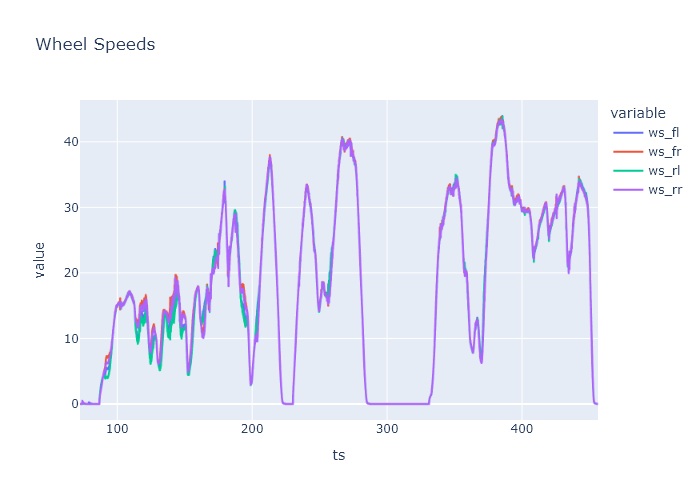

In [10]:
# wheel speeds를 그래프로 그린다.
fig_wheel_speeds = px.line(df_ws, x='ts', y=[f'ws_{wheel}' for wheel in wheels], title='Wheel Speeds')

# plotly로 그래프를 출력하고 html로 저장하면 파일 크기가 너무 커서 티스토리에서 포스팅을 할 수 없다. plolty 그래프를 png로 변환한다.
png_wheel_speeds = k_dir_project / 'fig_wheel_speeds.png'
fig_wheel_speeds.write_image(png_wheel_speeds)
img = Image.open(png_wheel_speeds)
display(img)


## 메시지 별로 데이터프레임 만들기

In [13]:
# 필요한 신호들이 들어있는 메시지들을 확인한다.
messages = set()
signals_to_find = ['SAS_Angle', 'YAW_RATE', 'LAT_ACCEL', 'CYL_PRES', 'LONG_ACCEL']
trace_keys = list(trace.keys())
for trace_key in trace_keys[:3]: # 전체 trace_key를 모두 출력하면 너무 많아서 3개만 출력한다.
    for signal in signals_to_find:
        if signal in trace_key:
            channel, message_name, *signal_name_parts = trace_key.split('_')
            signal_name = '_'.join(signal_name_parts)
            messages.add(message_name)
            print(f'{signal_name} found in {channel}/{message_name}')

print()
print(f'{signals_to_find} are found in {messages}')


['SAS_Angle', 'YAW_RATE', 'LAT_ACCEL', 'CYL_PRES', 'LONG_ACCEL'] are found in set()


- 필요한 신호들의 trace_key들을 확인하였다. 운이 좋았다. 메시지 이름에 '_'가 없었다. 그랬다면 위와 같이 간단히 찾을 수 없었을 것이다.   

In [14]:
# 메시지 별로 데이터프레임을 만든다.  

# 제동 성능 지표 계산에 필요한 신호들이 속한 메시지들은 아래 messages 리스트와 같다.  
messages = ['CAN1_WHL_SPD11', 'CAN1_SAS11', 'CAN1_ESP12']

# 각 메시지에 속한 신호들을 읽어서 데이터프레임을 만든다.
signal_map = {} # dict of dict

signal_map['CAN1_WHL_SPD11'] = {
    # mat 파일의 trace_key: df의 컬럼 이름 
    'CAN1_WHL_SPD11_WHL_SPD_FL': 'ws_fl',   
    'CAN1_WHL_SPD11_WHL_SPD_FR': 'ws_fr',
    'CAN1_WHL_SPD11_WHL_SPD_RL': 'ws_rl',
    'CAN1_WHL_SPD11_WHL_SPD_RR': 'ws_rr',
}
signal_map['CAN1_SAS11'] = {
    'CAN1_SAS11_SAS_Angle': 'sas',
}
signal_map['CAN1_ESP12'] = {
    'CAN1_ESP12_YAW_RATE': 'yaw_rate',
    'CAN1_ESP12_LAT_ACCEL': 'lat_accel',
    'CAN1_ESP12_CYL_PRES': 'cyl_pres',
    'CAN1_ESP12_LONG_ACCEL': 'long_accel'
}

dfs = {}
for message in messages:
    print(f'Processing {message}')
    df = pd.DataFrame()
    for k, v in signal_map[message].items():
        df[f'ts_{v}'] = np.array(trace[k])[0, :] # 시그널 별로 ts를 따로 읽을 필요는 없는데 ... 귀찮다.
        df[v] = np.array(trace[k])[1, :]
    df['ts'] = df[f'ts_{list(signal_map[message].values())[0]}']
    df.drop(columns=[f'ts_{v}' for v in signal_map[message].values()], inplace=True)
    df = df[['ts'] + list(signal_map[message].values())]
    dfs[message] = df


Processing CAN1_WHL_SPD11
Processing CAN1_SAS11
Processing CAN1_ESP12


Plotting CAN1_WHL_SPD11


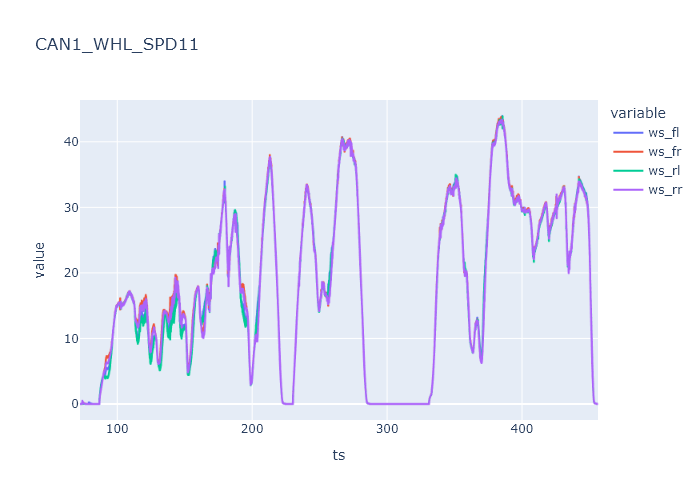

Plotting CAN1_SAS11


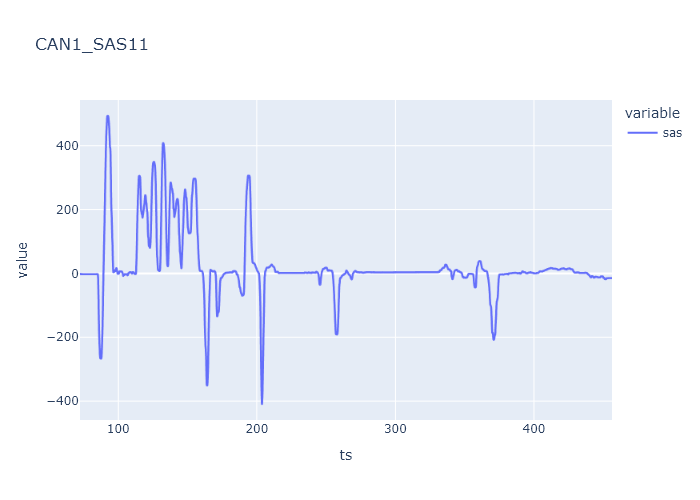

Plotting CAN1_ESP12


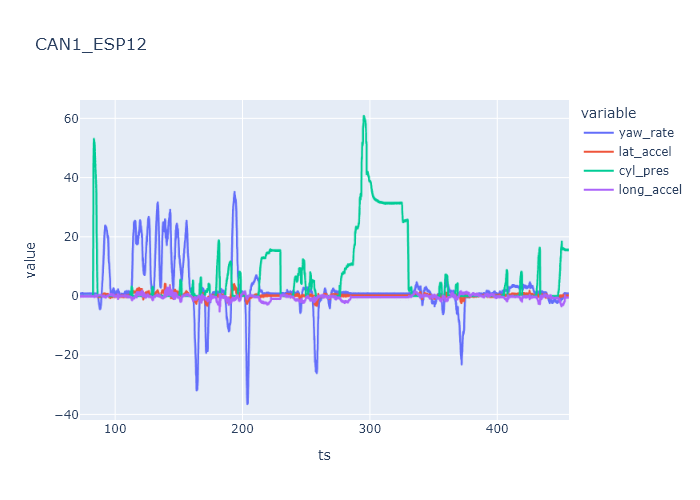

In [15]:
# 메시지 별로 데이터프레이들이 제대로 만들어졌는지 그래프를 그려서 확인한다.
for message in messages:
    print(f'Plotting {message}')
    fig_histogram_period_message = px.line(dfs[message], x='ts', y=list(signal_map[message].values()), title=message)
    fig_histogram_period_message.write_image(f'{message}.png')
    img = Image.open(f'{message}.png')
    display(img)
    # fig_histogram_period_message.show()

- 메시지별로 데이터프레임이 잘 만들어졌다.

## 메시지별로 만든 데이터프레임들을 한 데이터프레임으로 합친다.
- 메시지들 별로 타임스탬프가 다르다. 
- 기준을 정해서 타임스탬프들을 하나로 만든다.
- 메시지별 데이터프레임들을 합쳐서 한 데이터프레임으로 만든다.

In [16]:
# 메시지 별 df의 프레임의 개수를 확인한다.
for message in messages:
    print(f'dfs[{message}].shape = {dfs[message].shape}') 


dfs[CAN1_WHL_SPD11].shape = (19196, 5)
dfs[CAN1_SAS11].shape = (38394, 2)
dfs[CAN1_ESP12].shape = (38392, 5)


- WHL_SPD11의 프레임 개수와 SAS11의 프레임 개수는 2배 정도 차이가 난다. 메지시 전송 주기가 2배 정도 차이가 나는 것으로 짐작할 수 있다.
- SAS11의 프레임 개수와 ESP12의 프레임 개수는 거의 같다.

dfs[CAN1_WHL_SPD11].shape = (19196, 5)


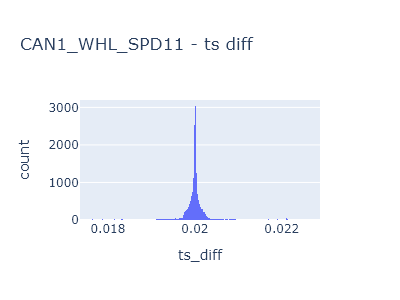

dfs[CAN1_SAS11].shape = (38394, 2)


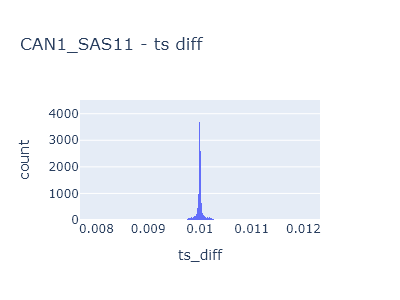

dfs[CAN1_ESP12].shape = (38392, 5)


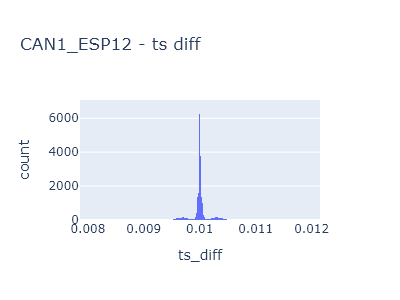

In [17]:
# 메시지별로 프레임 전송 주기를 구한다. 
for message in messages:
    print(f'dfs[{message}].shape = {dfs[message].shape}')
    dfs[message]['ts_diff'] = dfs[message]['ts'].diff()
    fig_histogram_period_message =  px.histogram(
        dfs[message],
        x='ts_diff',
        title=f'{message} - ts diff',
        width=400,
        height=300,
    )
    fig_histogram_period_message.write_image(f'{message}_ts_diff.png')
    img = Image.open(f'{message}_ts_diff.png')
    display(img)
    # fig_histogram_period_message.show()


- WHL_SPD11의 전송 주기는 20msec이다.
- SAS11과 ESP12의 전송 주기는 10msec이다.

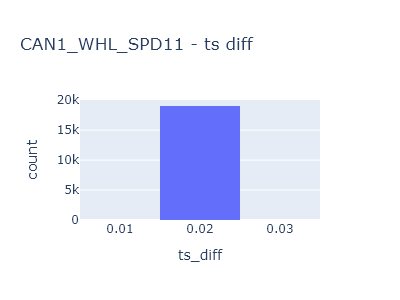

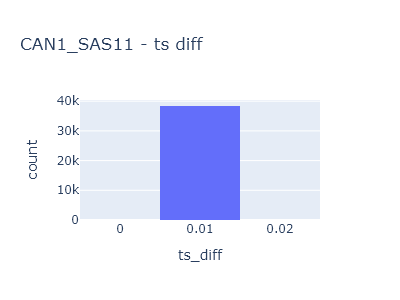

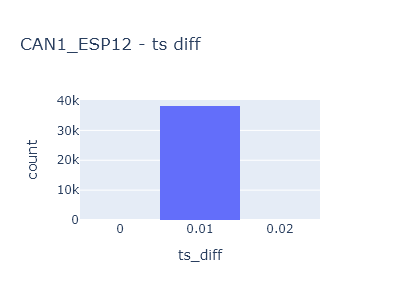

In [18]:
# [경고] 아래 조작은 ts를 덮어쓰기 때문에 1회만 해야한다. 
# 반복하면 왜곡이 발생하고 반복할 수록 왜곡이 심해진다. 

for message in messages:
    # 전체 프레임의 ts에서 첫 프레임의 ts를 뺀다. 첫 프레임의 ts는 0이 된다.
    dfs[message]['ts'] = dfs[message]['ts'] - dfs[message]['ts'].iloc[0]

    # ts를 0.01초(10msec. 세 메시지의 가장 짧은 전송 주기) 단위로 만든다.
    # dfs[message]['ts'] = (dfs[message]['ts'] * 100).astype(int) / 100. 이 방법 보다는 아래 방법이 직관적이다.
    dfs[message]['ts'] = dfs[message]['ts'].round(2)
    
    # ts_diff를 구한다.
    dfs[message]['ts_diff'] = dfs[message]['ts'].diff()

    # ts_diff를 히스토그램으로 그린다.
    fig_histogram_period_message =  px.histogram(
        dfs[message],
        x='ts_diff',
        title=f'{message} - ts diff',
    )

    # fig1의 크기를 400x300으로 만든다.
    fig_histogram_period_message.update_layout(
        width=400,
        height=300,
    )

    fig_histogram_period_message.write_image(f'{message}_ts_diff_rounded.png')
    img = Image.open(f'{message}_ts_diff_rounded.png')
    display(img)
    # fig_histogram_period_message.show()

- 히스토그램의 ts_diff의 간격이 10msec로 변경되었다. 
- 일부는 0msec로 다른 일부는 20msec가 되었다. 즉, ts 간격이 5msec 보다 작거나, 15msec 보다 큰 경우가 있었다는 이야기다. 제어기의 연산 주기가 변해서 일 수도 있고, CAN 메시지 전송을 위한 버스 점유가 지연되서 일 수도 있고, 두 가지가 겹쳐서 일 수도 있겠다.   

In [19]:
# histogram을 그리기 위해서 임시로 만든 ts_diff 컬럼을 제거한다.
for message in messages:
    dfs[message].drop(columns=['ts_diff'], inplace=True)
    
# CAN1_WHL_SPD11, CAN1_SAS11, CAN1_ESP12를 merge한다.
df = pd.merge(dfs['CAN1_WHL_SPD11'], dfs['CAN1_SAS11'], on='ts', how='outer')
df = pd.merge(df, dfs['CAN1_ESP12'], on='ts', how='outer')  

# na를 forward fill한다. 결과적으로 na를 last valid value로 채우는 셈이된다. 
df = df.ffill() 

# 중복을 제거한다.
df.drop_duplicates(subset='ts', inplace=True)

In [20]:
# df를 살펴본다.
df.tail(3)

,ts,ws_fl,ws_fr,ws_rl,ws_rr,sas,yaw_rate,lat_accel,cyl_pres,long_accel
38513,383.91,0.0,0.0,0.0,0.0,-14.6,0.92,0.10,15.6,-0.53
38514,383.92,0.0,0.0,0.0,0.0,-14.6,0.86,0.12,15.5,-0.57
38515,383.93,0.0,0.0,0.0,0.0,-14.6,0.84,0.15,15.5,-0.57


## 그래프로 데이터프레임들이 제대로 합쳐졌는지 확인한다.

In [21]:
def plot_driving(df):
    '''   
     3 x 1의 subplots를 그린다.
    1번째 plot은 wheel speeds를 그린다.
    2번째 plot은 long_accel을 그린다.
    3번째 plot은 cyl_pres를 그린다.
    '''
    
    if 'brake_state' in df.columns:
        fig = make_subplots(rows=7, cols=1, shared_xaxes=True, vertical_spacing=0.02)
        fig.add_trace(go.Scatter(x=df['ts'], y=df['brake_state'], mode='lines', name='brake_state'), row=7, col=1)
        fig.update_yaxes(title_text='brake_state', row=7, col=1)
    else:
        fig = make_subplots(rows=6, cols=1, shared_xaxes=True, vertical_spacing=0.02)
    
    fig.add_trace(go.Scatter(x=df['ts'], y=df['ws_fl'], mode='lines', name='ws_fl'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['ts'], y=df['ws_fr'], mode='lines', name='ws_fr'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['ts'], y=df['ws_rl'], mode='lines', name='ws_rl'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['ts'], y=df['ws_rr'], mode='lines', name='ws_rr'), row=1, col=1)
    # wheel speeds의 단위는 km/h이다. y축의 단위를 km/h로 표시한다.
    fig.update_yaxes(title_text='ws<br>km/h', row=1, col=1)

    fig.add_trace(go.Scatter(x=df['ts'], y=df['cyl_pres'], mode='lines', name='cyl_pres'), row=2, col=1)
    # cyl_pres의 단위는 bar이다.
    fig.update_yaxes(title_text='cyl_pres<br>bar', row=2, col=1)

    fig.add_trace(go.Scatter(x=df['ts'], y=df['long_accel'], mode='lines', name='long_accel'), row=3, col=1)
    # long_accel의 단위는 m/s^2이다.
    fig.update_yaxes(title_text='long_decel<br>m/s^2', row=3, col=1)

    fig.add_trace(go.Scatter(x=df['ts'], y=df['sas'], mode='lines', name='sas'), row=4, col=1)
    # sas_angle의 단위는 degree이다.
    fig.update_yaxes(title_text='sas<br>degree', row=4, col=1)

    fig.add_trace(go.Scatter(x=df['ts'], y=df['yaw_rate'], mode='lines', name='yaw_rate'), row=5, col=1)
    # yaw_rate의 단위는 degree/s이다.
    fig.update_yaxes(title_text='yaw_rate<br>degree/s', row=5, col=1)

    fig.add_trace(go.Scatter(x=df['ts'], y=df['lat_accel'], mode='lines', name='lat_accel'), row=6, col=1)
    # lat_accel의 단위는 m/s^2이다.
    fig.update_yaxes(title_text='lat_accel<br>m/s^2', row=6, col=1)

    fig.update_layout(title=f'{mat.name}', height=800, width=800, showlegend=True)

    # 선의 굵기를 1로 한다.
    fig.update_traces(line=dict(width=0.5), row=1, col=1)
    fig.update_traces(line=dict(width=0.5), row=2, col=1)
    fig.update_traces(line=dict(width=0.5), row=3, col=1)
    fig.update_traces(line=dict(width=0.5), row=4, col=1)
    fig.update_traces(line=dict(width=0.5), row=5, col=1)
    fig.update_traces(line=dict(width=0.5), row=6, col=1)

    return fig


In [22]:
def calc_brake_state(df):
    '''
    cyl_pres와 wheel_speeds를 이용하여 brake_state를 계산한다.

    brake_state
        0: no braking, moving, 
        1: no braking, stop
        2: braking, moving
        3: braking, stop
    '''

    # 나중에 fillna를 하기 위해서 숫자가(예 -1) 아닌 None으로 초기화한다.
    df['brake_state'] = None   

    # cyl_pres의 오셋 보정을 한다. 
    # 오히려 안 좋아졌다.
    # 다시 cyl_pres의 오셋 보정을 하는 시간 낭비를 피하기 위해서 주석 처리한다.
    
    # cyl_pres_min = df['cyl_pres'].min()
    # df['cyl_pres'] = df['cyl_pres'] - cyl_pres_min
    
    # 0으로 하면 노이즈로 false triggering이 발생한다.
    k_cyl_pres_brake_applied = 3.0  

    # 0으로 하면 CAN의 ws 신호들은 filtered normalized wheel speed라서 0이 되기까지 지나치게 오래 걸린다.
    k_vs_moving = 0.25              

    for i_row, row in df.iterrows():
        # 코딩을 편하게 하기 위해서 변수를 만든다.
        ts = row['ts']
        ws_fl = row['ws_fl']
        ws_fr = row['ws_fr']
        ws_rl = row['ws_rl']
        ws_rr = row['ws_rr']
        vs_min = min(ws_fl, ws_fr, ws_rl, ws_rr)
        vs_max = max(ws_fl, ws_fr, ws_rl, ws_rr)
        sas = row['sas']
        yaw_rate = row['yaw_rate']
        lat_accel = row['lat_accel']
        cyl_pres = row['cyl_pres']
        long_accel = row['long_accel']

        if cyl_pres < k_cyl_pres_brake_applied: # no braking
            if vs_min > k_vs_moving:   
                # no braking, moving
                df.loc[i_row, 'brake_state'] = 0
            else:
                # no braking, stop
                df.loc[i_row, 'brake_state'] = 1
        else: # braking
            if vs_min > k_vs_moving:     
                # braking, moving
                df.loc[i_row, 'brake_state'] = 2
            else:
                # braking, stop
                df.loc[i_row, 'brake_state'] = 3

    df['brake_state'] = df['brake_state'].astype('category').ffill()

    return df

In [23]:
# 데이터프레임에 brake_state를 추가한다.
df = calc_brake_state(df)

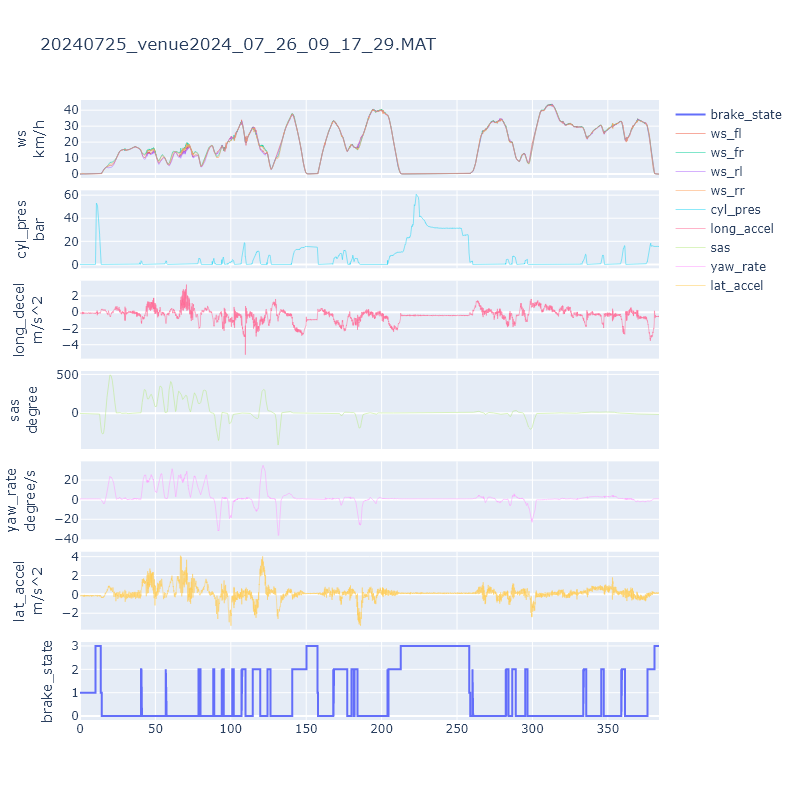

In [24]:
# brake_state 신호가 추가된 데이터프레임을 그래프로 그린다.
fig_driving = plot_driving(df)
fig_driving.write_image('fig_driving.png')
img = Image.open('fig_driving.png')
display(img)

- brake_state가 잘 계산되었다.

## 데이터프레임을 feather 파일로 저장한다.

In [25]:
# 데이터프레임을 feather 파일로 저장한다. feather 파일은 데이터프레임을 빠르게 저장하고 읽을 수 있는 파일 포맷이다.
df.to_feather(feather)

## 결론 - 메시지별로 만든 데이터프레임들을 한 데이터프레임으로 합치기

- 메시지별로 전송 주기가 다르다. 메시지별 데이터프레임을 합칠 때는 이를 고려해야 한다.
- 가장 빠른 전송 주기를 기준으로 ts를 만들었다.
- ts를 기준으로 데이터프레임들을 merge했다.
- merge된 데이터프레임에서 na 값을 ffill로 채웠다. 이는 last valid value로 채운셈이다.
- 여러 메시지들의 ts를 일치시키는 과정에서 오류가 발생한다. ts 오차는 메시지 전송 주기보다 작을 것이다. 이 오차가 제동 성능 지표 계산에 심각한 영향을 끼칠 것으로 생각하지 않는다. 
- ts 오류를 최소화 하기 위해서는 ts를 일치시키지 않고 메시지 별 ts를 이용해서 계산을 할 수도 있다. 그렇게 할 수 있지만 복잡하다. 메시지의 타임스탬프가 제어기의 타임스탬프는 아니다. 즉, 타임스탬프에는 이미 오차는 존재한다. 
- 이 스크립트는 데모 목적이다. ts를 일치시키며 값들을 보간(interpolation)할 수도 있다. 그렇게 할 정도의 정확도가 필요하지 않을 것으로 생각한다. 복잡하지 않은 현재 방식으로 ts를 맞춘다. 